# Project

Lucas MONTAGNIER, Adrien LESÉNÉCHAL

## Project Overview: Recognition of On-line Handwritten Mathematical Expression
#### Models:
Three models were used for this project:
- **Segmenter**: Groups strokes into symbols.
- **Classifier**: Recognizes symbols and assigns them a class.
- **Analyzer**: Establishes relationships between symbols.

The architectures of the models, training functions, and their evaluations are detailed in the sections of this notebook. The three trained models are in the models folder.

**Dataset Creation:** 9 datasets have been created for train, validation, and test sets for each task from the same inkml files in the data folder.

#### General execution flow (main function):
1. **Segmentation:** Application of the segmenter on strokes, resulting in an LG file with grouped strokes.
2. **Classification:** Application of the classifier on symbols, producing an LG file with recognized symbols.
3. **Hypothesis Selection:** Application of an algorithm to select the best hypotheses for symbols.
4. **Symbolic Relationship Analysis:** Application of the analyzer to create relationships between the recognized symbols.
5. **Equation Tree Selection:** Application of an algorithm to select the best tree of the found equation.

## Configuration

In [19]:
%pip install matplotlib networkx numpy pandas scikit-image torch torchmetrics torchvision

In [20]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import operator
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import xml.etree.ElementTree as ET

from collections.abc import Iterator
from convertInkmlToImg import convert_to_imgs, get_traces_data, getStrokesFromLG, parse_inkml as parse_inkml_traces, parseLG
from copy import deepcopy
from enum import Enum
from functools import reduce
from glob import glob
from io import StringIO
from math import sqrt
from numpy import array, ndarray
from pathlib import Path
from segmenter import generateHypSeg, toLG
from segmentSelect import computeProbSeg
from selectBestSeg import parseLGscore
from skimage.io import imsave
from sys import exc_info
from torch import Tensor, tensor
from torch.nn import Module
from torch.optim import Optimizer
from torch.utils.data import DataLoader, Dataset, default_collate, random_split, Subset
from torchmetrics.classification import BinaryConfusionMatrix, BinaryROC
from torchvision.utils import make_grid
from typing import Any, Callable, TypeVar

In [21]:
os.environ['HTTP_PROXY'] = 'http://cache.ha.univ-nantes.fr:3128'
os.environ['HTTPS_PROXY'] = 'http://cache.ha.univ-nantes.fr:3128'

data_dir = './data'
model_dir = './models'

T = TypeVar('T')
U = TypeVar('U')

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Utility declarations

### Data processing

In [23]:
def tensor_to_list(x: Tensor) -> list:
    '''Converts a tensor to a list of values.

    Args:
        x (Tensor): The tensor to convert.

    Returns:
        list: The generated list.
    '''
    return x.squeeze().cpu().numpy().tolist()

def imshow(img: Tensor, file_name: str | None = None) -> None:
    '''Shows an image.

    Args:
        img (Tensor): The image to show.
        file_name (str, optional): The location of the disk file to save the image to. The image is displayed if not specified.
    '''
    img = img / 2 + 0.5
    npimg = np.transpose(img.cpu().numpy(), (1, 2, 0))

    plt.imshow(npimg)
    if file_name is None:
        plt.show()
    else:
        plt.savefig(file_name)

In [24]:
XML = '{http://www.w3.org/XML/1998/namespace}'
INKML = '{http://www.w3.org/2003/InkML}'
MATHML = '{http://www.w3.org/1998/Math/MathML}'

Point = tuple[int, int]
Trace = list[Point]

class Relation(Enum):
    '''A relation between two symbols.
    '''
    RIGHT = 'Right'
    SUB = 'Sub'
    SUP = 'Sup'
    ABOVE = 'Above'
    BELOW = 'Below'
    INSIDE = 'Inside'

class LGFile:
    '''Representation of an LG file.
    '''

    def __init__(self) -> None:
        '''Creates a new LG file representation.
        '''
        self.traces: dict[str, Trace] = {}
        self.symbols: dict[str, tuple[str, list[int]]] = {}
        self.layout: dict[tuple[str, str], Relation] = {}

        self.symbol_probs: dict[str, float] = {}
        self.layout_probs: dict[tuple[str, str], float] = {}

    def get_traces(self, ids: list[int]) -> list[Trace]:
        '''Gets a list of full traces.

        Args:
            ids (list[int]): The list of trace IDs.

        Returns:
            list[Trace]: The list of all dots, for each given trace ID.
        '''
        return get_traces_data(self.traces, list(map(str, ids)))

    def get_symbol_prob(self, id: str) -> float:
        '''Gets the probability associated to a symbol, combining the probability of the traces to form a symbol and of the group to represent this specific symbol.

        Args:
            id (str): The trace group ID.

        Returns:
            float: The trace group andd symbol probability.
        '''
        if id in self.symbol_probs:
            return self.symbol_probs[id]
        if id in self.symbols:
            return 1.0
        return 0.0

    def get_layout_prob(self, src: str, dst: str) -> float:
        '''Gets the probability associated to a spatial relation between two symbols.

        Args:
            src (str): The first symbol ID.
            dst (str): The second symbol ID.

        Returns:
            float: The spatial relation probability.
        '''
        if (src, dst) in self.layout_probs:
            return self.layout_probs[src, dst]
        if (src, dst) in self.layout:
            return 1.0
        return 0.0
    
    def symbols_to_str(self) -> str:
        '''Gets the LG file representation of all symbols.

        Returns:
            str: The LG file string, one line per symbol.
        '''
        s = ''
        for symbol_id, (symbol, traces) in self.symbols.items():
            s += ', '.join(['O', symbol_id, symbol, str(self.get_symbol_prob(symbol_id))] + [str(t) for t in traces]) + '\n'
        return s
    
    def layout_to_str(self) -> str:
        '''Gets the LG file representation of all spatial relations.

        Returns:
            str: The LG file string, one line per spatial relation.
        '''
        s = ''
        for (src, dst), relation in self.layout.items():
            s += ', '.join(['R', src, dst, str(relation), str(self.get_layout_prob(src, dst))]) + '\n'
        return s

    def __repr__(self) -> str:
        '''Gets the full LG file representation.

        Returns:
            str: The LG file string, one line per symbol and spatial relation.
        '''
        return self.symbols_to_str() + self.layout_to_str()

class InkMLFile(LGFile):
    '''Representation of an LG file, extracted from an InkML file.
    '''

    def __init__(self, file_path: str) -> None:
        '''Creates a new LG file representation from an existing InkML file.

        Args:
            file_path (str): The InkML file path.
        '''
        super().__init__()
        self.file_path = file_path

        ok = False
        try:
            self.root: ET.Element = ET.parse(file_path).getroot()
            ok = True
        finally:
            if (not ok): print(self.file_path)

        self.parse_inkml_traces()
        self.parse_inkml_symbols()
        self.parse_layout()

    def parse_inkml_traces(self) -> None:
        '''Extracts the trace data from the InkML file.
        '''
        raw_traces: dict[str, list[list[int]]] = parse_inkml_traces(self.file_path)
        for k in raw_traces:
            self.traces[k] = [(p[0], p[1]) for p in raw_traces[k]]

    def parse_inkml_symbols(self) -> None:
        '''Extracts the trace group and symbol data from the InkML file.
        '''
        groups = self.root.find(INKML + 'traceGroup')
        if groups is None:
            raise Exception('missing trace groups in file "%s"' % self.file_path)
        for group in groups.findall(INKML + 'traceGroup'):
            annotation_xml = group.find(INKML + 'annotationXML')
            if annotation_xml is None:
                continue
            group_id = annotation_xml.get('href')
            if group_id is None:
                raise Exception('missing ID for stroke group in file "%s"' % self.file_path)
            annotation = group.find(INKML + 'annotation')
            if annotation is None:
                raise Exception('missing symbol annotation for stroke group in file "%s"' % self.file_path)
            text = annotation.text
            if text is None:
                raise Exception('missing symbol annotation text for stroke group in file "%s"' % self.file_path)
            trace_ids: list[int] = []
            for trace_view in group.findall(INKML + 'traceView'):
                ref = trace_view.get('traceDataRef')
                if ref is None:
                    raise Exception('missing trace reference in stroke group in file "%s"' % self.file_path)
                trace_ids.append(int(ref))
            self.symbols[group_id] = text, trace_ids

    def find_in_math(self, element: ET.Element, path: str) -> ET.Element | None:
        return element.find(self.math_ns + path)
    
    def get_in_math(self, element: ET.Element, key: str) -> str | None:
        return element.get(self.math_ns + key)

    def get_id(self, element: ET.Element) -> str:
        id = element.get(XML + 'id')
        if id is None:
            raise Exception('missing ID in file "%s"' % self.file_path)
        return id

    def has_any_type(self, element: ET.Element, *paths: str) -> bool:
        for path in paths:
            if element.tag == self.math_ns + path:
                return True
        return False

    def parse_layout(self) -> None:
        '''Extracts the statial relation data from the InkML file.
        '''
        annotation_xml = self.root.find(INKML + 'annotationXML')
        if annotation_xml is None:
            raise Exception('missing math annotation tag in file "%s"' % self.file_path)
        for math_ns in [MATHML, INKML]:
            self.math_ns = math_ns
            math = self.find_in_math(annotation_xml, 'math')
            if math is None:
                continue
            self.parse_node(next(iter(math)))
            return
        raise Exception('missing math expression tag in file "%s", maybe it uses another namespace?' % self.file_path)

    def parse_op_node(self, element: ET.Element, *rels: Relation) -> str:
        es = list(iter(element))
        ids = list(map(self.parse_node, es))
        for i in range(len(rels)):
            self.layout[ids[i], ids[i+1]] = rels[i]
        return ids[0]

    def parse_op_node_with_parent(self, element: ET.Element, rel1: Relation, *relsn: Relation) -> str:
        es = list(iter(element))
        id1 = self.get_id(element)
        id2s = list(map(self.parse_node, es))
        self.layout[id1, id2s[0]] = rel1
        for i in range(len(id2s)-1):
            self.layout[id2s[i], id2s[i+1]] = relsn[i]
        return id1

    def parse_row_node(self, element: ET.Element, reln: Relation) -> str:
        es = list(iter(element))
        ids = list(map(self.parse_node, es))
        for i in range(len(ids)-1):
            self.layout[ids[i], ids[i+1]] = reln
        return ids[0]

    def parse_row_node_with_parent(self, element: ET.Element, rel1: Relation, reln: Relation) -> str:
        es = list(iter(element))
        id1 = self.get_id(element)
        id2s = list(map(self.parse_node, es))
        self.layout[id1, id2s[0]] = rel1
        for i in range(len(id2s)-1):
            self.layout[id2s[i], id2s[i+1]] = reln
        return id1

    def parse_node(self, element: ET.Element) -> str:
        if self.has_any_type(element, 'mi', 'mn', 'mo'):
            return self.get_id(element)
        if self.has_any_type(element, 'mfrac'):
            return self.parse_op_node_with_parent(element, Relation.ABOVE, Relation.BELOW)
        if self.has_any_type(element, 'mover'):
            return self.parse_op_node(element, Relation.ABOVE)
        if self.has_any_type(element, 'mroot'):
            return self.parse_op_node_with_parent(element, Relation.INSIDE, Relation.ABOVE)
        if self.has_any_type(element, 'mrow'):
            return self.parse_row_node(element, Relation.RIGHT)
        if self.has_any_type(element, 'msqrt'):
            return self.parse_row_node_with_parent(element, Relation.INSIDE, Relation.RIGHT)
        if self.has_any_type(element, 'msub'):
            return self.parse_op_node(element, Relation.SUB)
        if self.has_any_type(element, 'msubsup'):
            return self.parse_op_node(element, Relation.SUB, Relation.SUP)
        if self.has_any_type(element, 'msup'):
            return self.parse_op_node(element, Relation.SUP)
        if self.has_any_type(element, 'munder'):
            return self.parse_op_node(element, Relation.BELOW)
        if self.has_any_type(element, 'munderover'):
            return self.parse_op_node(element, Relation.BELOW, Relation.ABOVE)
        raise Exception('unknown math tag: ' + element.tag)

In [25]:
Splittedset = tuple[Subset[T], Subset[T], Subset[T]]

def build_data(name: str, input_path: str, splits: tuple[float, float, float]) -> None:
    '''Generates a base dataset by splitting a list of InkML files into a train, a validation, and a test dataset.

    Args:
        name (str): The dataset name.
        input_path (str): The InkML files path.
        splits (tuple[float, float, float]): The splitting proportion of each of the 3 subsets.
    '''
    path = Path('./%s.pt' % name)
    if path.exists():
        return
    data: Dataset[InkMLFile] = list(map(InkMLFile, glob(input_path + '/**/*.inkml', recursive=True)))
    torch.save(random_split(data, splits, torch.Generator().manual_seed(69)), path)

def load_data(name: str) -> Splittedset[T]:
    '''Loads a dataset from a file.

    Args:
        name (str): The dataset name.

    Returns:
        Splittedset[T]: The loaded dataset.
    '''
    return torch.load('./%s.pt' % name)

def format_data(input_name: str, output_name: str, formatter: Callable[[T], Iterator[U]]) -> None:
    '''Generates a new dataset by modifying an existing one.

    Args:
        input_name (str): The name of the source dataset.
        output_name (str): The name of the target dataset.
        formatter (Callable[[T], Iterator[U]]): The function to generate new data from the source data.
    '''
    outpout_path = Path('./%s.pt' % output_name)
    if outpout_path.exists():
        return
    input_data: Splittedset[T] = torch.load('./%s.pt' % input_name)
    output_data = (
        [r for e in input_data[0] for r in formatter(e)],
        [r for e in input_data[1] for r in formatter(e)],
        [r for e in input_data[2] for r in formatter(e)],
    )
    torch.save(output_data, outpout_path)

def make_loaders(data: Splittedset[T], batch_size: int = 32) -> tuple[DataLoader[T], DataLoader[T], DataLoader[T]]:
    '''Creates PyTorch loaders for a dataset.

    Args:
        data (Splittedset[T]): The dataset to create loaders on
        batch_size (int, optional): The batch size. Defaults to 32.

    Returns:
        tuple[DataLoader[T], DataLoader[T], DataLoader[T]]: The 3 loaders for the train, validation, and test subsets.
    '''
    def _collate_to_device(data: list[T]):
        return tuple(x_.to(device) for x_ in default_collate(data))
    return (
        DataLoader(data[0], batch_size, True, collate_fn=_collate_to_device),
        DataLoader(data[1], batch_size, collate_fn=_collate_to_device),
        DataLoader(data[2], batch_size, collate_fn=_collate_to_device)
    )

In [26]:
build_data('data', './data', (.8, .1, .1))
data = load_data('data')
tuple(map(len, data))

(7069, 883, 883)

In [27]:
def class_counts(data: Splittedset[tuple[Any, int]], classes: list[T]) -> dict[T, int]:
    '''Gets the number of occurrences of each class, on a dataset for a classification task.

    Args:
        data (Splittedset[tuple[Any, int]]): The classification dataset.
        classes (list[T]): The expected classes.

    Returns:
        dict[T, int]: The number of occurrences within the dataset for each expected class.
    '''
    counts = {c: 0 for c in classes}
    for d in data:
        for _, c in d:
            counts[classes[c]] += 1
    return counts

def sqrt_weights(data: Splittedset[tuple[Any, int]], classes: list[T]) -> Tensor:
    counts = class_counts(data, classes)
    return tensor([1 / sqrt(counts[k]) for k in counts], dtype=torch.float, device=device)

def one_over_weights(data: Splittedset[tuple[Any, int]], classes: list[T]) -> Tensor:
    counts = class_counts(data, classes)
    return tensor([20 / counts[k] for k in counts], dtype=torch.float, device=device)

def dynamic_weights(data: Splittedset[tuple[Any, int]], classes: list[T], epoch: int) -> Tensor:
    counts = class_counts(data, classes)
    return tensor([max(1, 100 * epoch - counts[k]) for k in counts], dtype=torch.float, device=device)

### Model training

In [10]:
class Model:
    '''Base class for trainable models, which provides a basic interface for training and testing a model.

    Creation of a subclass is expected for use with any specific task.
    '''

    @staticmethod
    def load(name: str) -> 'Model':
        '''Loads a saved model from a file.

        Args:
            name (str): The model name.

        Returns:
            Model: The loaded model.
        '''
        model: Model = torch.load('%s/%s' % (model_dir, name))

        model.net.to(device)
        model.best_net.to(device)

        print(model.net)

        return model

    def __init__(self, net: Module, optimizer: Optimizer, criterion: Module) -> None:
        '''Creates a new model.

        Args:
            net (Module): The trainable network.
            optimizer (Optimizer): The optimizer used during training.
            criterion (Module): The criterion used during training.
        '''
        self.net = net.to(device)
        self.optimizer = optimizer
        self.criterion = criterion

        self.train_samples = array([])
        self.train_loss = array([])
        self.val_loss = array([])

        self.best_net = deepcopy(net).eval()
        self.best_train_epoch = 0
        self.best_val_epoch = 0
        self.best_train_loss = 1000000
        self.best_val_loss = 1000000

        print(self.net)

    def save(self, name: str) -> None:
        '''Saves the model to a disk file.

        Args:
            name (str): The name of the model.
        '''
        torch.save(self, '%s/%s' % (model_dir, name))
    
    def epoch_count(self) -> int:
        '''Gets the number of epochs the model has be trained on.

        Returns:
            int: The number of times the network was fed with the full dataset.
        '''
        return self.train_samples.size

    def train(self, epochs: int, train_loader: DataLoader, val_loader: DataLoader) -> bool:
        '''Trains the model for a few new epochs.

        Args:
            epochs (int): The number of epochs to train the model.
            train_loader (DataLoader): The train data.
            val_loader (DataLoader): The validation data.

        Returns:
            bool: True if this training changed the best configuration, false otherwise.
        '''
        val_improved = False
        first_epoch = len(self.train_samples) + 1
        train_samples = self.train_samples[-1] if first_epoch > 1 else 0

        # for each epoch, ...
        for epoch in range(first_epoch, first_epoch + epochs):
            train_samples += len(train_loader.dataset)

            # ... feed the network with training data, update the weights accordingly, ...
            train_loss = self.run_on(train_loader)

            # ... feed the network with validation data, ...
            with torch.no_grad():
                val_loss = self.run_on(val_loader)

            # ... store loss, ...
            self.train_samples = np.append(self.train_samples, train_samples)
            self.train_loss = np.append(self.train_loss, train_loss)
            self.val_loss = np.append(self.val_loss, val_loss)

            # ... and update the best model.
            if train_loss < self.best_train_loss:
                self.best_train_epoch = epoch
                self.best_train_loss = train_loss
            if val_loss < self.best_val_loss:
                val_improved = True
                self.best_net = deepcopy(self.net).eval()
                self.best_val_epoch = epoch
                self.best_val_loss = val_loss

            print('%s Epoch %d:\t\tmean train loss = %.6f\t\tmean eval. loss = %.6f' % (
                '★' if self.best_val_epoch == epoch else ' ',
                epoch,
                train_loss, val_loss
            ))

        return val_improved

    def get_outputs(self, inputs: Tensor) -> Tensor:
        '''Computes the output tensor from an input one, using the current model configuration.

        Args:
            inputs (Tensor): The tensor to give to the model.

        Returns:
            Tensor: The output tensor.
        '''
        return self.net(inputs)

    def get_best_outputs(self, inputs: Tensor) -> Tensor:
        '''Computes the output tensor from an input one, using the best model configuration.

        Args:
            inputs (Tensor): The tensor to give to the model.

        Returns:
            Tensor: The output tensor.
        '''
        return self.best_net(inputs)

    def get_loss(self, outputs: Tensor, labels: Tensor) -> Tensor:
        '''Computes the loss by comparing an output tensor and a ground truth one.

        Args:
            outputs (Tensor): The output tensor, supposedly obtained from the current best configuration.
            labels (Tensor): The ground truth tensor.

        Returns:
            Tensor: The loss values tensor.
        '''
        return self.criterion(outputs, labels)

    def run_on(self, data_loader: DataLoader) -> float:
        '''Feeds data to the net, and computes the mean loss. Weights are updated if gradient is enabled.

        Args:
            data_loader (DataLoader): The data to feed the model with.

        Returns:
            float: The mean loss value.
        '''
        full_loss = 0.0

        # for each batch, ...
        for inputs, labels in data_loader:
            if torch.is_grad_enabled():
                self.optimizer.zero_grad()

            # ... feed the network, ...
            outputs = self.get_outputs(inputs)

            # ... compute the associated loss, ...
            loss = self.get_loss(outputs, labels)
            full_loss += loss.item()

            # ... and update the weights.
            if torch.is_grad_enabled():
                loss.backward()
                self.optimizer.step()

        full_loss /= len(data_loader.dataset)
        return full_loss
    
    def plot_loss_curves(self, x_min: int = 1, file_name: str | None = None):
        '''Plots curves of the output loss values, for all previous training epochs.

        Args:
            x_min (int, optional): The first epoch to consider. Defaults to 1.
            file_name (str, optional): The location of the disk file to save the plot to. The plot is displayed if not specified.
        '''
        x_axis = list(range(1, len(self.train_samples) + 1))
        x_min -= 1
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.plot(
            x_axis[x_min:], self.train_loss.tolist()[x_min:], 'r',
            x_axis[x_min:], self.val_loss.tolist()[x_min:], 'b',
            [self.best_train_epoch], [self.best_train_loss], 'ro',
            [self.best_val_epoch], [self.best_val_loss], 'bo'
        )
        if file_name is None:
            plt.show()
        else:
            plt.savefig(file_name)

## Segmentation

This first CNN is used to predict the probability that an image composed of strokes is one symbol.

### Dataset

In [11]:
def format_for_segmentation(inkml: InkMLFile) -> Iterator[tuple[Tensor, float]]:
    '''Formats an InkML file for the segmentation task, which uses:
    - Input: a 32x32 image tensor, generated from 1+ strokes.
    - Output: 1.0 if the image represents a single character, 0.0 otherwise.

    Args:
        inkml (InkMLFile): The inkml file to generate samples from.

    Yields:
        Iterator[tuple[Tensor, float]]: A generator of samples, with inputs and ground truths.
    '''
    hyplist = generateHypSeg(len(inkml.traces))
    hyplist_gt = [inkml.symbols[k][1] for k in inkml.symbols]
    for hyp in hyplist:
        truth = 1. if hyp in hyplist_gt else 0.
        img = convert_to_imgs(inkml.get_traces(hyp), 32) / 255
        img = torch.tensor([img.tolist()])
        yield img, truth

In [12]:
format_data('data', 'data_segmenter', format_for_segmentation)
data: Splittedset[tuple[Tensor, float]] = load_data('data_segmenter')
train_loader, val_loader, test_loader = make_loaders(data)
len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset)

KeyboardInterrupt: 

In [ ]:
# get some random training images
inputs, labels = next(iter(train_loader))

# show images
imshow(make_grid(inputs))
# print labels
print(tensor_to_list(labels))

### Model architectures

In [28]:
class SegmentationModel(Model):
    '''A trainable model for segmentation.
    '''

    @staticmethod
    def load(name: str) -> 'SegmentationModel':
        return Model.load(name)

    def __init__(self, net: Module, optimizer: Optimizer, criterion: Module = nn.BCELoss()) -> None:
        '''Creates a new model for segmentation.

        Args:
            net (Module): The trainable network.
            optimizer (Optimizer): The optimizer used during training.
            criterion (Module, optional): The criterion used during training. Defaults to cross entropy.
        '''
        super().__init__(net, optimizer, criterion)

    def get_loss(self, outputs: Tensor, labels: Tensor) -> Tensor:
        return super().get_loss(outputs, labels.float())

    def accuracy(self, data_loader: DataLoader, threshold: float = 0.5) -> float:
        '''Feeds data to the network, then computes the associated accuracy.

        Args:
            data_loader (DataLoader): The data to feed the model with.
            threshold (float, optional): The binary classification threshold. Defaults to 0.5.

        Returns:
            float: The network accuracy on the given data.
        '''
        correct = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = self.get_best_outputs(inputs)
                predicted = (outputs > threshold).float()
                correct += int((predicted == labels.to(device)).sum().item())
        return correct / len(data_loader.dataset)

In [29]:
class NetCNN(Module):
    def __init__(self, conv_size_1: int, conv_size_2: int, layer_size_1: int, layer_size_2: int):
        super(NetCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, conv_size_1, 5)
        self.conv2 = nn.Conv2d(conv_size_1, conv_size_2, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(conv_size_2 * 5 * 5, layer_size_1)
        self.fc2 = nn.Linear(layer_size_1, layer_size_2)
        self.fc3 = nn.Linear(layer_size_2, 1)

    def forward(self, x: Tensor) -> Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.conv2.out_channels * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x.flatten()

### Model training

In [ ]:
# net = NetCNN(16, 32, 100, 50)

# segmenter = SegmentationModel(net, optim.Adadelta(net.parameters()))
segmenter = SegmentationModel.load('cnn_segmenter_917')

In [ ]:
# segmenter.train(10, train_loader, val_loader)

In [ ]:
# segmenter.save('cnn_segmenter922')

In [ ]:
plt.title('Segmenter')
segmenter.plot_loss_curves()

### Model evaluation

#### Recognition rate

In [ ]:
print('Accuracy of the network on the test images: %3.2f %%' % (100.0 * segmenter.accuracy(test_loader)))
print('Accuracy of the network on the train images: %3.2f %%' % (100.0 * segmenter.accuracy(train_loader)))

#### Confusion matrix

In [ ]:
with torch.no_grad():
    test_outputs = torch.cat(list(segmenter.get_best_outputs(inputs) for inputs, _ in test_loader))
test_labels = torch.cat(list(labels.to(device) for _, labels in test_loader)).int()

confmat = BinaryConfusionMatrix(threshold=0.4).to(device)
result = confmat(test_outputs, test_labels)
confmat.plot()
result

#### ROC curve

In [ ]:
metric = BinaryROC(100).to(device)
fpr, tpr, thresholds = metric(test_outputs, test_labels)
_ = metric.plot(score=True)

In [ ]:
optimal_idx = np.argmax((tpr - fpr).cpu())
optimal_threshold = thresholds[optimal_idx].item()
optimal_threshold

## Symbol recognition

### Dataset

In [13]:
symbol_classes = ['!', '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'V', 'X', 'Y', '[', '\\Delta', '\\alpha', '\\beta', '\\cos', '\\div', '\\exists', '\\forall', '\\gamma', '\\geq', '\\gt', '\\in', '\\infty', '\\int', '\\lambda', '\\ldots', '\\leq', '\\lim', '\\log', '\\lt', '\\mu', '\\neq', '\\phi', '\\pi', '\\pm', '\\prime', '\\rightarrow', '\\sigma', '\\sin', '\\sqrt', '\\sum', '\\tan', '\\theta', '\\times', '\\{', '\\}', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|']
symbol_classes.sort()

print(symbol_classes)
nb_classes = len(symbol_classes)
print('%d classes' % nb_classes)

['!', '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'V', 'X', 'Y', '[', '\\Delta', '\\alpha', '\\beta', '\\cos', '\\div', '\\exists', '\\forall', '\\gamma', '\\geq', '\\gt', '\\in', '\\infty', '\\int', '\\lambda', '\\ldots', '\\leq', '\\lim', '\\log', '\\lt', '\\mu', '\\neq', '\\phi', '\\pi', '\\pm', '\\prime', '\\rightarrow', '\\sigma', '\\sin', '\\sqrt', '\\sum', '\\tan', '\\theta', '\\times', '\\{', '\\}', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|']
101 classes


In [14]:
def format_for_classification(inkml: InkMLFile) -> Iterator[tuple[Tensor, int]]:
    '''Formats an InkML file for the symbol classification task, which uses:
    - Input: a 32x32 image tensor, generated from a stroke group.
    - Output: the symbol the image represents.

    Args:
        inkml (InkMLFile): The inkml file to generate samples from.

    Yields:
        Iterator[tuple[Tensor, float]]: A generator of samples, with inputs and ground truths.
    '''
    for k in inkml.symbols:
        symbol, hyp = inkml.symbols[k]
        img = convert_to_imgs(inkml.get_traces(hyp), 32) / 255
        img = torch.tensor([img.tolist()])
        yield img, symbol_classes.index(symbol)

In [15]:
format_data('data', 'data_classifier', format_for_classification)
data: Splittedset[tuple[Tensor, int]] = load_data('data_classifier')
train_loader, val_loader, test_loader = make_loaders(data)
len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset)

KeyboardInterrupt: 

In [ ]:
# get some random training images
inputs, labels = next(iter(train_loader))

# show images
imshow(make_grid(inputs))
# print labels
print('  '.join('%5s' % symbol_classes[labels[j]] for j in range(8)))

### Model architectures

In [30]:
class RecognitionModel(Model):
    '''A trainable model for symbol recognition.
    '''

    @staticmethod
    def load(name: str) -> 'RecognitionModel':
        return Model.load(name)

    def __init__(self, net: Module, optimizer: Optimizer, criterion: Module = nn.CrossEntropyLoss()) -> None:
        '''Creates a new model for symbol recognition.

        Args:
            net (Module): The trainable network.
            optimizer (Optimizer): The optimizer used during training.
            criterion (Module, optional): The criterion used during training. Defaults to cross entropy.
        '''
        super().__init__(net, optimizer, criterion)

    def accuracy(self, data_loader: DataLoader) -> float:
        '''Feeds data to the network, then computes the associated accuracy.

        Args:
            data_loader (DataLoader): The data to feed the model with.

        Returns:
            float: The network accuracy on the given data.
        '''
        correct = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = self.get_best_outputs(inputs)
                _, predicted = torch.max(outputs.data, 1)
                correct += int((predicted == labels.to(device)).sum().item())
        return correct / len(data_loader.dataset)

In [31]:
class NetCNN2(Module):
    def __init__(self, conv_size_1: int, conv_size_2: int, layer_size_1:int, layer_size_2:int):
        super(NetCNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, conv_size_1, 5)
        self.conv2 = nn.Conv2d(conv_size_1, conv_size_2, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(conv_size_2 * 5 * 5, layer_size_1)
        self.fc2 = nn.Linear(layer_size_1, layer_size_2)
        self.fc3 = nn.Linear(layer_size_2, nb_classes)

    def forward(self, x: Tensor) -> Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.conv2.out_channels * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x))
        return x

class NetCNN3(Module):
    def __init__(self, conv_size_1: int, conv_size_2: int, conv_size_3: int, layer_size_1:int, layer_size_2:int):
        super(NetCNN3, self).__init__()
        self.conv1 = nn.Conv2d(1, conv_size_1, 3)
        self.conv2 = nn.Conv2d(conv_size_1, conv_size_2, 3)
        self.conv3 = nn.Conv2d(conv_size_2, conv_size_3, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(conv_size_3 * 6 * 6, layer_size_1)
        self.fc2 = nn.Linear(layer_size_1, layer_size_2)
        self.fc3 = nn.Linear(layer_size_2, nb_classes)
        self.drop = nn.Dropout(0.1)
        self.relu = nn.Sigmoid()

    def forward(self, x: Tensor) -> Tensor:
        # 32*32 * 1
        x = self.relu(self.conv1(x))
        # 30*30 * conv_size_1
        x = self.relu(self.conv2(x))
        # 28*28 * conv_size_2
        x = self.pool(x)
        x = self.drop(x)
        # 14*14 * conv_size_2
        x = self.relu(self.conv3(x))
        # 12*12 * conv_size_3
        x = self.pool(x)
        x = self.drop(x)
        # 6*6 * conv_size_3
        x = x.view(-1, self.fc1.in_features)
        # 36 * conv_size_3
        x = self.relu(self.fc1(x))
        x = self.drop(x)
        x = self.relu(self.fc2(x))
        x = self.drop(x)
        x = F.softmax(self.fc3(x))
        return x


### Model training

In [ ]:
# net = NetCNN3(12, 24, 36, 500, 200).to(device)
# net = NetCNN2(60, 80, 900, 400).to(device)
# net = NetCNN2(48, 128, 800, 300).to(device)
# net = NetCNN3(6, 12, 18, 200, 150).to(device)
# net = NetCNN2(16, 24, 200, 150).to(device)

# criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(sqrt_weights(data, symbol_classes))
# criterion = FocalLoss(2)

# classifier = RecognitionModel(net, optim.Adadelta(net.parameters()), criterion)
classifier = RecognitionModel.load('cnn_classifier_ink_907_81c')

sum(map(torch.numel, classifier.net.parameters()))

In [ ]:
# classifier.train(100, train_loader, val_loader)
# for _ in range(10):
#     classifier.criterion = nn.CrossEntropyLoss(dynamic_weights(data, symbol_classes, classifier.epoch_count()))
#     classifier.train(1, train_loader, val_loader)

In [ ]:
# classifier.save('cnn_classifier_ink_75')

In [ ]:
plt.title('Classifier')
classifier.plot_loss_curves()

### Model evaluation

#### Recognition rate

In [ ]:
# Check the results for each class
class_correct = list(0. for _ in range(nb_classes))
class_total = list(0. for _ in range(nb_classes))
class_probs = list(0. for _ in range(nb_classes))

full_predicted = []
full_labels = []

#best_model2 = load_model('cnn_classif68')
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = classifier.get_best_outputs(inputs)
        predicted_probs, predicted = torch.max(outputs.data, 1)
        full_predicted.append(predicted)
        full_labels.append(labels)
        c = (predicted == labels.to(device)).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            class_probs[label] += predicted_probs[i].item()


full_predicted = torch.cat(full_predicted)
full_labels = torch.cat(full_labels)
#for predicted, label in zip(full_predicted,full_labels):
#    print(classes[label], classes[predicted])

print('Accuracy of the network on the test images: %3.2f %%' % (100.0 * classifier.accuracy(test_loader)))

# compute ... and show results
count_class_ok = len([class_correct[i] for i in range(nb_classes) if class_total[i] > 0 and class_correct[i] / class_total[i] > 0.5])
print(str(count_class_ok)+"/"+str(nb_classes))

for i in range(nb_classes):
    if class_total[i] > 0 :
        
        print('Accuracy of %s : %3.2f %% (%d/%d)\t\t%3.2f %%' % (
            symbol_classes[i], 100.0 * class_correct[i] / class_total[i], class_correct[i], class_total[i], 100.0 * class_probs[i] / class_total[i]))
    else:
        print('No %5s sample' % (symbol_classes[i]))

## Layout Analysis

### Dataset

In [41]:
layout_classes = ['Above', 'Below', 'Inside', 'None', 'Right', 'Sub', 'Sup']
layout_classes.sort()

print(layout_classes)
nb_classes = len(layout_classes)
print('%d classes' % nb_classes)

['Above', 'Below', 'Inside', 'None', 'Right', 'Sub', 'Sup']
7 classes


In [37]:
def get_all_symbol_properties(group1: list[Trace], group2: list[Trace]) -> list[float]:
    '''Extracts a list of various features from a pair of symbols.

    Args:
        group1 (list[Trace]): The first symbol.
        group2 (list[Trace]): The second symbol.

    Returns:
        list[float]: The list of numeric features extracted.
    '''
    x_1, y_1 = map(list, zip(*[list(p) for strk in group1 for p in strk]))
    x_2, y_2 = map(list, zip(*[list(p) for strk in group2 for p in strk]))

    min_x = min(x_1 + x_2)
    x_1 = [i - min_x for i in x_1]
    x_2 = [i - min_x for i in x_2]
    min_y = min(y_1 + y_2)
    y_1 = [i - min_y for i in y_1]
    y_2 = [i - min_y for i in y_2]

    max_x = max(x_1 + x_2)
    x_1 = [i / max_x for i in x_1]
    x_2 = [i / max_x for i in x_2]
    max_y = max(y_1 + y_2)
    y_1 = [i / max_y for i in y_1]
    y_2 = [i / max_y for i in y_2]

    min_x_1 = min(x_1)
    max_x_1 = max(x_1)
    group1_size_x = max_x_1 - min_x_1
    min_y_1 = min(y_1)
    max_y_1 = max(y_1)
    group1_size_y = max_y_1 - min_y_1
    min_x_2 = min(x_2)
    max_x_2 = max(x_2)
    group2_size_x = max_x_2 - min_x_2
    min_y_2 = min(y_2)
    max_y_2 = max(y_2)
    group2_size_y = max_y_2 - min_y_2

    center_1 = [min_x_1 + max_x_1 / 2, min_y_1 + max_y_1 / 2]
    center_2 = [min_x_2 + max_x_2 / 2, min_y_2 + max_y_2 / 2]
    distance = sqrt((center_1[0] - center_2[0]) ** 2 + (center_1[1] - center_2[1]) ** 2)

    return [
        min_x_1, max_x_1, group1_size_x, # 0-2
        min_y_1, max_y_1, group1_size_y, # 3-5
        min_x_2, max_x_2, group2_size_x, # 6-8
        min_y_2, max_y_2, group2_size_y, # 9-11
        distance, *center_1, *center_2 # 12-16
    ]

def get_symbol_bounds(group1: list[Trace], group2: list[Trace]) -> list[tuple[float, float]]:
    '''Extracts normalized bounding features of a pair of symbols.

    Args:
        group1 (list[Trace]): The first symbol.
        group2 (list[Trace]): The second symbol.

    Returns:
        list[float]: The list of point features extracted.
    '''
    x1, y1 = map(list, zip(*[list(p) for strk in group1 for p in strk]))
    x2, y2 = map(list, zip(*[list(p) for strk in group2 for p in strk]))

    min_x = min(x1 + x2)
    x1 = [i - min_x for i in x1]
    x2 = [i - min_x for i in x2]
    min_y = min(y1 + y2)
    y1 = [i - min_y for i in y1]
    y2 = [i - min_y for i in y2]

    max_x = max(x1 + x2)
    x1 = [i / max_x for i in x1]
    x2 = [i / max_x for i in x2]
    max_y = max(y1 + y2)
    y1 = [i / max_y for i in y1]
    y2 = [i / max_y for i in y2]

    return [
        (min(x1), min(y1)),
        (max(x1), max(y1)),
        (min(x2), min(y2)),
        (max(x2), max(y2)),
    ]

def format_for_layout_analysis(inkml: InkMLFile) -> Iterator[tuple[Tensor, int]]:
    '''Formats an InkML file for the layout analysis task, which uses:
    - Input: a tensor of various numeric features, extracted from the boundaries of 2 symbols.
    - Output: the spatial relation between the 2 symbols, or "None" if there is not any.

    Args:
        inkml (InkMLFile): The inkml file to generate samples from.

    Yields:
        Iterator[tuple[Tensor, float]]: A generator of samples, with inputs and ground truths.
    '''
    for g1 in inkml.symbols:
        for g2 in inkml.symbols:
            if g1 == g2: continue
            truth = inkml.layout[g1, g2].value if (g1, g2) in inkml.layout else 'None'
            s1 = inkml.get_traces(inkml.symbols[g1][1])
            s2 = inkml.get_traces(inkml.symbols[g2][1])
            yield tensor(get_all_symbol_properties(s1, s2)), layout_classes.index(truth)

def format_normalized_for_layout_analysis(inkml: InkMLFile) -> Iterator[tuple[Tensor, int]]:
    '''Formats an InkML file for the layout analysis task, which uses:
    - Input: a tensor of normalized symbol bound numeric features, extracted from 2 symbols.
    - Output: the spatial relation between the 2 symbols, or "None" if there is not any.

    Args:
        inkml (InkMLFile): The inkml file to generate samples from.

    Yields:
        Iterator[tuple[Tensor, float]]: A generator of samples, with inputs and ground truths.
    '''
    for g1 in inkml.symbols:
        for g2 in inkml.symbols:
            if g1 == g2: continue
            truth = inkml.layout[g1, g2].value if (g1, g2) in inkml.layout else 'None'
            s1 = inkml.get_traces(inkml.symbols[g1][1])
            s2 = inkml.get_traces(inkml.symbols[g2][1])
            yield tensor(get_symbol_bounds(s1, s2)), layout_classes.index(truth)

In [ ]:
format_data('data', 'data_layout_analyzer', format_for_layout_analysis)
format_data('data', 'data_layout_analyzer_norm', format_normalized_for_layout_analysis)

data: Splittedset[tuple[list[float], int]] = load_data('data_layout_analyzer')
# data: Splittedset[tuple[list[float], int]] = load_data('data_layout_analyzer_norm')

train_loader, val_loader, test_loader = make_loaders(data)
len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset)

### Architecture

In [32]:
class LayoutAnalysisModel(Model):
    '''A trainable model for layout analysis.
    '''

    @staticmethod
    def load(name: str) -> 'LayoutAnalysisModel':
        return Model.load(name)

    def __init__(self, net: Module, optimizer: Optimizer, criterion: Module = nn.CrossEntropyLoss()) -> None:
        '''Creates a new model for layout analysis.

        Args:
            net (Module): The trainable network.
            optimizer (Optimizer): The optimizer used during training.
            criterion (Module, optional): The criterion used during training. Defaults to cross entropy.
        '''
        super().__init__(net, optimizer, criterion)

    def accuracy(self, data_loader: DataLoader) -> float:
        '''Feeds data to the network, then computes the associated accuracy.

        Args:
            data_loader (DataLoader): The data to feed the model with.

        Returns:
            float: The network accuracy on the given data.
        '''
        correct = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = self.get_best_outputs(inputs)
                _, predicted = torch.max(outputs.data, 1)
                correct += int((predicted == labels.to(device)).sum().item())
        return correct / len(data_loader.dataset)

In [33]:
class CenterTransformer(Module):
    def forward(self, x: Tensor) -> Tensor:
        min1, max1, min2, max2 = x[:, 0], x[:, 1], x[:, 2], x[:, 3]
        c1, c2 = (min1 + max1) / 2, (min2 + max2) / 2
        return torch.stack([c1, c2], dim=1)

class AngleTransformer(Module):
    def forward(self, x: Tensor) -> Tensor:
        d = x[:, 0] - x[:, 1]
        a = torch.view_as_complex(d).angle()
        return torch.stack([a.cos(), a.sin(), d.norm(dim=1)], dim=1)

In [34]:
class NetCNNlayout(Module):
    def __init__(self, layer_size_1: int, layer_size_2: int) -> None:
        super(NetCNNlayout, self).__init__()
        self.fc1 = nn.Linear(17, layer_size_1)
        self.fc2 = nn.Linear(layer_size_1, layer_size_2)
        self.fc3 = nn.Linear(layer_size_2, nb_classes)

    def forward(self, x: Tensor) -> Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x))
        return x

class MaskedNetLayout(Module):
    def __init__(self, connections: list[list[int]]) -> None:
        super(MaskedNetLayout, self).__init__()

        def backward_hook(grad):
            out = grad.clone()
            out[self.mask] = 0
            return out

        layer_size = len(connections)

        self.mask = torch.ones([layer_size, 17]).bool()
        for i in range(len(connections)):
            for j in connections[i]:
                self.mask[i, j] = False

        self.fc1 = nn.Linear(17, layer_size)
        self.fc2 = nn.Linear(layer_size, nb_classes)
        self.fc1.weight.data[self.mask] = 0
        self.fc1.weight.register_hook(backward_hook)

    def forward(self, x: Tensor) -> Tensor:
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x

class AngleNetLayout(Module):
    def __init__(self, layer_size_1: int, layer_size_2: int) -> None:
        super(AngleNetLayout, self).__init__()

        self.transform_center = CenterTransformer()
        self.transform_angle = AngleTransformer()
        self.fc1 = nn.Linear(3, layer_size_1)
        self.fc2 = nn.Linear(layer_size_1, layer_size_2)
        self.fc3 = nn.Linear(layer_size_2, nb_classes)

    def forward(self, x: Tensor) -> Tensor:
        x = self.transform_center(x)
        x = self.transform_angle(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x))
        return x

In [ ]:
def layout_weights(data: Splittedset[tuple[Any, int]], classes: list[T]) -> Tensor:
    counts = class_counts(data, classes).values()
    largest_class_size = max(counts)
    return tensor([largest_class_size / c for c in counts], dtype=torch.float, device=device)

def layout_dynamic_weights(data: Splittedset[tuple[Any, int]], classes: list[T], epoch: int) -> Tensor:
    counts = class_counts(data, classes)
    return tensor([max(0.01, 8000+2000 * epoch - counts[k]) for k in counts], dtype=torch.float, device=device)

lweights = layout_weights(data, layout_classes)
lweights

In [ ]:
# net = NetCNNlayout(64, 32).to(device)
# net = MaskedNetLayout([
#     [ 0, 1, 2, 6, 7, 8, 13, 15 ],
#     [ 3, 4, 5, 9, 10, 11, 14, 16 ],
#     [ 12 ]
# ])

# net = MaskedNetLayout([
#     [ 13, 15 ],
#     [ 14, 16 ],
#     [ 14, 16 ]
# ])
# net.fc1.weight.data[0, 13] = 1
# net.fc1.weight.data[0, 15] = -1
# net.fc1.weight.data[1, 14] = 1
# net.fc1.weight.data[1, 16] = -1
# net.fc1.weight.data[2, 14] = -1
# net.fc1.weight.data[2, 16] = 1

# net = AngleNetLayout(16, 8)

# xp = (A*x2 - B*x1 > C)
# yp = (D*y2 - E*y1 > F)
# yn = (G*y1 - H*y2 > I)

# 'RIGHT'  <==   xp /\ -yp /\ -yn
# 'ABOVE'  <==  -xp /\  yp
# 'BELOW'  <==  -xp        /\  yn
# 'SUP'    <==   xp        /\  yn
# 'SUB'    <==   xp        /\  yn
# 'INNER'  <==   xp        /\  yn

# criterion = nn.CrossEntropyLoss(lweights)
# analyser = LayoutAnalysisModel(net, optim.SGD(net.parameters(), 0.0000001), criterion)
# analyser = LayoutAnalysisModel(net, optim.Adadelta(net.parameters()), criterion)
# analyser = LayoutAnalysisModel(net, optim.Adam(net.parameters(), 0.0001), criterion)
analyser = LayoutAnalysisModel.load('mlp_analyser_885_6c')

sum(map(torch.numel, analyser.net.parameters()))

In [ ]:
# analyser.criterion = nn.CrossEntropyLoss(lweights)
# analyser.optimizer = optim.Adam(net.parameters(), 0.0000001)
# analyser.train(10, train_loader, val_loader)

In [ ]:
# analyser.save('mlp_analyser_RBSup')

In [ ]:
analyser.plot_loss_curves()

In [ ]:
# Check the results for each class
class_correct = list(0. for _ in range(nb_classes))
class_total = list(0. for _ in range(nb_classes))
class_probs = list(0. for _ in range(nb_classes))

full_predicted = []
full_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = analyser.get_best_outputs(inputs)
        predicted_probs, predicted = torch.max(outputs.data, 1)
        full_predicted.append(predicted)
        full_labels.append(labels)
        c = (predicted == labels.to(device)).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            class_probs[label] += predicted_probs[i].item()


full_predicted = torch.cat(full_predicted)
full_labels = torch.cat(full_labels)
#for predicted, label in zip(full_predicted,full_labels):
#    print(classes[label], classes[predicted])

print('Accuracy of the network on the test images: %3.2f %%' % (100.0 * analyser.accuracy(test_loader)))

# compute ... and show results
count_class_ok = len([class_correct[i] for i in range(nb_classes) if class_total[i] > 0 and class_correct[i] / class_total[i] > 0.5])
print('%d/%d' % (count_class_ok, nb_classes))

for i in range(nb_classes):
    if class_total[i] > 0 :
        
        print('Accuracy of %s : %3.2f %% (%d/%d)\t\t%3.2f %%' % (
            layout_classes[i], 100.0 * class_correct[i] / class_total[i], class_correct[i], class_total[i], 100.0 * class_probs[i] / class_total[i]))
    else:
        print('No %5s sample' % (layout_classes[i]))

## MAIN

In [39]:
segmenter = SegmentationModel.load('cnn_segmenter_917')
classifier = RecognitionModel.load('cnn_classifier_ink_907_81c')
analyzer = LayoutAnalysisModel.load('mlp_analyser_885_6c')

NetCNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=500, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)
NetCNN2(
  (conv1): Conv2d(1, 60, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(60, 80, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2000, out_features=900, bias=True)
  (fc2): Linear(in_features=900, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=101, bias=True)
)
NetCNNlayout(
  (fc1): Linear(in_features=17, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=7, bias=True)
)


input = ./data/MfrDB/MfrDB0039.inkml
--- Choosen symbols ---
O, hyp0, *, 1.0, 0
O, hyp2, *, 1.0, 2
O, hyp3, *, 1.0, 3
O, hyp6, *, 1.0, 6
O, hyp7, *, 1.0, 7
O, hyp8, *, 1.0, 8
O, hyp11, *, 1.0, 11
O, hyp12, *, 0.9973065853118896, 12
O, hyp13, *, 1.0, 13
O, hyp16, *, 1.0, 16
O, hyp17, *, 1.0, 17
O, hyp19, *, 1.0, 19
O, hyp20, *, 1.0, 20
O, hyp21, *, 1.0, 21
O, hyp22, *, 1.0, 0, 1
O, hyp27, *, 1.0, 5, 6
O, hyp31, *, 1.0, 9, 10
O, hyp33, *, 1.0, 11, 12
O, hyp36, *, 1.0, 14, 15
O, hyp39, *, 1.0, 17, 18

--- Symbols Reco ---
O, hyp0, i, 1.0, 0
O, hyp2, (, 1.0, 2
O, hyp3, ,, 1.0, 3
O, hyp6, 1, 1.0, 6
O, hyp7, y, 1.0, 7
O, hyp8, ), 1.0, 8
O, hyp11, \int, 1.0, 11
O, hyp12, -, 0.9973065853118896, 12
O, hyp13, (, 1.0, 13
O, hyp16, ), 1.0, 16
O, hyp17, \int, 1.0, 17
O, hyp19, (, 1.0, 19
O, hyp20, y, 1.0, 20
O, hyp21, ), 1.0, 21
O, hyp22, i, 1.0, 0, 1
O, hyp27, +, 1.0, 5, 6
O, hyp31, =, 1.0, 9, 10
O, hyp33, f, 1.0, 11, 12
O, hyp36, x, 1.0, 14, 15
O, hyp39, f, 1.0, 17, 18

--- Best Segmentation ---


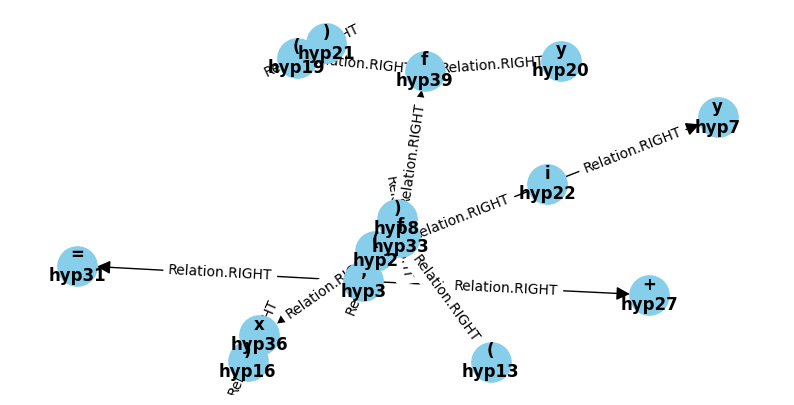

None


In [42]:
def compute_prob_seg(lg: LGFile, hyp: list[int]) -> float:
    '''Takes an hypothesis (from LG = list of stroke index), selects the corresponding strokes (from allTraces) and 
    returns the probability of being a good segmentation [0:1].
    '''
    im = convert_to_imgs(lg.get_traces(hyp), 32)
    im = torch.tensor(im).float().unsqueeze(0).to(device)
    result_proba = segmenter.get_best_outputs(im)
    return float(result_proba.item())

def compute_cl_prob(lg: LGFile, hyp: list[int], min_threshold: float = 0.0) -> dict[str, float]:
    '''Takes an hypothesis (from LG = list of stroke index), selects the corresponding strokes (from allTraces) and 
    returns the probability of being each symbol as a dictionnary {class_0 : score_0 ; ... class_i : score_i } .
    Only keep classes with a score higher than a threshold.
    '''
    im = convert_to_imgs(lg.get_traces(hyp), 32)
    im = torch.tensor(im).float().unsqueeze(0).to(device)
    result_proba = classifier.get_best_outputs(im)
    return {c: proba for c, proba in zip(symbol_classes, result_proba[0].tolist()) if proba > min_threshold}

def select_best_symbols(lg: LGFile) -> None:
    '''Filters out symbol hypothesis from an LG file to have each trace only be part of a single symbol.

    Args:
        lg (LGFile): The LG file representation.
    '''
    trace_sets = [(id, set(traces)) for id, (_, traces) in lg.symbols.items()]

    best_trace_count = 0
    best_trace_prob = 0.0
    best_solution: list[int] = []

    selected_solution: list[int] = []
    selected_traces: set[int] = set()

    i = 0
    while True:
        i += 1

        # find a symbol to add
        while i < len(trace_sets):
            if len(selected_traces & trace_sets[i][1]) == 0:
                break
            i += 1

        # found one, we add it
        if i < len(trace_sets):
            selected_solution.append(i)
            selected_traces |= trace_sets[i][1]

        # found none, the partition is full
        else:
            # update the best solution
            trace_count = len(selected_traces)
            trace_prob = reduce(operator.mul, (lg.symbol_probs[trace_sets[i][0]] for i in selected_solution), 1)
            if (trace_count, trace_prob) > (best_trace_count, best_trace_prob):
                best_trace_count = trace_count
                best_trace_prob = trace_prob
                best_solution = deepcopy(selected_solution)

            # stop if there is no remaining configuration to test
            if len(selected_solution) == 0:
                break

            # remove the last symbol
            i = selected_solution.pop()
            selected_traces -= trace_sets[i][1]

    # update LG
    lg.symbols = { trace_sets[i][0]: lg.symbols[trace_sets[i][0]] for i in best_solution }
    lg.symbol_probs = { trace_sets[i][0]: lg.symbol_probs[trace_sets[i][0]] for i in best_solution if trace_sets[i][0] in lg.symbol_probs }

def select_best_layout(lg: LGFile):
    '''Filters out spatial relation hypothesis from an LG file to form an arborescence.

    Args:
        lg (LGFile): The LG file representation.
    '''
    graph = nx.DiGraph()
    graph.add_edges_from((*k, {'weight': lg.get_layout_prob(*k)}) for k in lg.layout)

    arbo: nx.DiGraph = nx.maximum_spanning_arborescence(graph)
    best_solution: list[tuple[str, str]] = list(arbo.edges)

    # update LG
    lg.layout = { k: lg.layout[k] for k in best_solution }
    lg.layout_probs = { k: lg.layout_probs[k] for k in best_solution if k in lg.layout_probs }

def generate_pairs(lst: list[T]) -> Iterator[tuple[T, T]]:
    '''Generates all possible pairs in a list.

    Args:
        lst (list[T]): A list of elements.

    Yields:
        Iterator[tuple[T, T]]: A list of pairs.
    '''
    for i in range(len(lst)):
        for j in range(i + 1, len(lst)):
            yield lst[i], lst[j]
            yield lst[j], lst[i]

def compute_relations(lg: LGFile):
    '''Calls a layout analyzer to find spatial relations.

    Args:
        lg (LGFile): The LG file representation.
    '''
    for id1, id2 in generate_pairs(list(lg.symbols.keys())):
        features = get_all_symbol_properties(lg.get_traces(lg.symbols[id1][1]), lg.get_traces(lg.symbols[id2][1]))
        result_proba = analyzer.get_best_outputs(torch.tensor(features).to(device))
        # get the prediction
        class_prediction = layout_classes[result_proba.tolist().index(max(result_proba))]
        if class_prediction != 'None':
            lg.layout[id1, id2] = Relation(class_prediction)
            lg.layout_probs[id1, id2] = max(result_proba.tolist())

def build_tree(lg: LGFile):
    id_to_class = { id: '%s\n%s' % (symbol, id) for id, (symbol, _) in lg.symbols.items() }
    # read the input LG file as CSV
    input_data = StringIO(lg.layout_to_str())
    df = pd.read_csv(input_data, header=None, names=['Type', 'Hyp1', 'Hyp2', 'Direction', 'Valeur'], sep=',', skipinitialspace=True)
    df = df[df['Type'] == 'R']

    # sort using the 'Valeur' column in descending order
    df['Valeur'] = pd.to_numeric(df['Valeur'])
    df = df.sort_values(by='Valeur', ascending=False)

    # create a directed graph
    G = nx.DiGraph()

    for _, row in df.iterrows():
        G.add_edge(id_to_class[row['Hyp1']], id_to_class[row['Hyp2']], label=row['Direction'])

    # find the root node (a node with in-degree 0)
    roots = [next(iter(comp)) for comp in nx.weakly_connected_components(G)]
    roots = [node for node in G.nodes if G.in_degree(node) == 0]

    _, axes = plt.subplots(len(roots), 1, figsize=(10, 5*len(roots)))

    for i in range(len(roots)):
        ax = axes[i] if len(roots) > 1 else axes
        tree = nx.dfs_tree(G, source=roots[i])

        #pos = {}
        #for node in tree.nodes:
        #    pos[node] = (0, 0)  # Default position for all nodes

        #for edge in tree.edges:
        #    direction = G[edge[0]][edge[1]]['label']
        #    pos[edge[1]] = (pos[edge[0]][0] + 1, pos[edge[0]][1])

        # draw the tree with edge labels
        pos = nx.spring_layout(tree)
        nx.draw(tree, pos, with_labels=True, font_weight='bold', node_color='skyblue', node_size=800, arrowsize=20, ax=ax)
        edge_labels = {(u, v): G[u][v]['label'] for u, v in tree.edges}
        nx.draw_networkx_edge_labels(tree, pos, edge_labels=edge_labels, ax=ax)

    plt.show()

def main(inputInkml: str):
    # Generate from an inkml file hypotheses of symbol
    inkml = InkMLFile(inputInkml)
    print('input = ' + inputInkml)
    
    lg = LGFile()
    lg.traces = deepcopy(inkml.traces)

    hyplist: list[list[int]] = generateHypSeg(len(lg.traces))

    #-----------------------------------------------------------
    # Compute proba and keep or not each segment hypotheses
    for i, hyp in enumerate(hyplist):
        prob = compute_prob_seg(lg, hyp)
        if prob > 0.5:
            id = 'hyp%d' % i
            lg.symbols[id] = '*', hyp
            lg.symbol_probs[id] = prob

    print('--- Choosen symbols ---')
    print(lg)

    #-----------------------------------------------------------
    # Symbols Recognition
    for id, (_, hyp) in lg.symbols.items():
        # for each hypo, call the classifier and keep only selected classes (only the best or more)
        prob_dict = compute_cl_prob(lg, hyp, 0.05)
        # rewrite the new LG
        symbol, prob = max(prob_dict.items(), key=operator.itemgetter(1))
        lg.symbols[id] = symbol, hyp
        lg.symbol_probs[id] *= prob

    print('--- Symbols Reco ---')
    print(lg)

    #-----------------------------------------------------------
    # Select best segmentation
    select_best_symbols(lg)

    print('--- Best Segmentation ---')
    print(lg)

    #-----------------------------------------------------------
    # Layout analysis
    compute_relations(lg)

    print('--- Layout Analysis ---')
    print(lg)

    #-----------------------------------------------------------
    # Select best layout
    select_best_layout(lg)

    print('--- Best Layout ---')
    print(lg)
    
    print('--- Graph ---')
    print(build_tree(lg))

with torch.no_grad():
    main('./data/MfrDB/MfrDB0039.inkml')